# 深層学習　共通の前処理

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import tensorflow as tf
import keras
import gensim

from keras import backend as K
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding,Activation,LSTM,Dropout,Conv1D,GlobalMaxPooling1D,Flatten,MaxPool1D,Conv2D,MaxPool2D
from keras.layers import RepeatVector,TimeDistributed,Bidirectional,Permute,Input,multiply,Concatenate,Lambda,GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.callbacks import EarlyStopping,ModelCheckpoint
from gensim.models import KeyedVectors

Using TensorFlow backend.


In [ ]:
from keras.utils import plot_model

In [ ]:
%cd /content/drive/'My Drive'/'zemi_report'

/content/drive/My Drive/zemi_report


In [ ]:
#%cd /content/drive/'My Drive'/'zemi_report'

df=pd.read_csv('review_text.csv',header=0)
A=df.values
print(A.shape)

B=[]
for i in range(0,23486):
    if str(A[i,0])=='nan':
        np.delete(A,i,axis=0)
    else:
        B.append(A[i])
        
C=np.array(B)
print(C.shape)
df=pd.DataFrame(C)
#これがデータフレーム
df=df.rename(columns={0:'Review Text',1:'Recommended IND'})
df['Review Text']=df['Review Text'].astype('str')
df['Recommended IND']=df['Recommended IND'].astype('f')

(23486, 2)
(22641, 2)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
X_train,X_test,Y_train,Y_test=train_test_split(
    df['Review Text'],df['Recommended IND'],test_size=0.3,random_state=9)

class_weight2 = class_weight.compute_class_weight('balanced',
                                                  np.unique(df['Recommended IND'].values),
                                                df['Recommended IND'].values)
class_weight2 = {0:class_weight2[0],1:class_weight2[1]}
print(class_weight2)

{0: 2.760424286759327, 1: 0.6105987055016181}


In [ ]:
#混同行列を出す関数
from sklearn.metrics import confusion_matrix
def plot_cm(confmat):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.title('predicted label')
    plt.ylabel('true label')
    plt.tight_layout()
    plt.show()

In [ ]:
#自作の関数
#callbackで一度にrecall,precision,f1(マクロ平均を返す)
from sklearn.metrics import f1_score,recall_score,precision_score
from keras.callbacks import Callback

class MCallback(Callback):
    def __init__(self, model, X_val, y_val):
        self.model = model
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs):
        pred = self.model.predict(self.X_val)
        recall_val=recall_score(self.y_val, np.round(pred),average='macro')
        precision_val=precision_score(self.y_val, np.round(pred),average='macro')
        f1_val = f1_score(self.y_val, np.round(pred),average='macro')
        print([recall_val,precision_val,f1_val])
        plot_cm(confusion_matrix(self.y_val,np.round(pred)))

# Word2vecによる埋め込み



In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
x_train=tokenizer.texts_to_sequences(X_train)
x_test=tokenizer.texts_to_sequences(X_test)

max_len=200

x_train=pad_sequences(x_train,maxlen=max_len)
x_test=pad_sequences(x_test,maxlen=max_len)

vocab_size=len(tokenizer.word_index)+1
word_index = tokenizer.word_index

In [ ]:
embed_size=300
word2vec=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                                          binary=True)
embedding_weights = np.zeros((vocab_size,embed_size))
for word,index in word_index.items():
    try:
        embedding_weights[index,:]=word2vec[word]
    except KeyError:
        pass

In [ ]:
#attention機構 自作
#self_attention
#rnnの場合、embedding層の前がよい。
def Attention(inpu):
    x = Permute((2, 1))(inpu)
    x = Dense(max_len, activation='softmax')(x)
    x = Permute((2, 1))(x)
    output_attention_mul = multiply([inpu, x])
    return output_attention_mul

def LSTM_Attention(inpu):
    x=Permute((2,1))(inpu)
    x=Dense(max_len,activation='softmax')(x)
    x=Lambda(lambda a: K.mean(a,axis=1))(x)
    x=RepeatVector(hidden_size*2)(x)
    x=Permute((2,1))(x)
    output=multiply([inpu,x])
    return output

def LSTM_Attention1(inpu):
    x=Permute((2,1))(inpu)
    x=Dense(max_len,activation='softmax')(x)
    x=Lambda(lambda a: K.mean(a,axis=1))(x)
    x=RepeatVector(hidden_size*2)(x)
    x=Permute((2,1))(x)
    output=multiply([inpu,x])
    return output

In [ ]:
hidden_size=128

inp=Input(shape=(max_len,))
emb=Embedding(vocab_size,embed_size,weights=[embedding_weights],mask_zero=True)(inp)
lstm1=LSTM(hidden_size)(emb)
#att1=Attention_share(lstm1)
#lstm_mid=RepeatVector(max_len)(lstm1)
#lstm2=Bidirectional(LSTM(hidden_size))(lstm_mid)
drop=Dropout(0.2)(lstm1)
out=Dense(1,activation='sigmoid')(drop)

model=Model(inputs=inp,outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 300)          3828600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 4,048,377
Trainable params: 4,048,377
Non-trainable params: 0
_________________________________________________________________

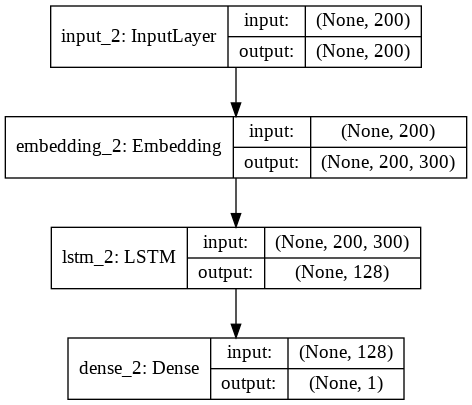

In [ ]:
plot_model(model,show_shapes=True,to_file='LSTM.model.png')



Train on 15848 samples, validate on 6793 samples
Epoch 1/8
15848/15848 [==============================] - 62s 4ms/step - loss: 0.4285 - acc: 0.7891 - val_loss: 0.3932 - val_acc: 0.8172
[0.8574757382561017, 0.7365294873594957, 0.7601934141107098]


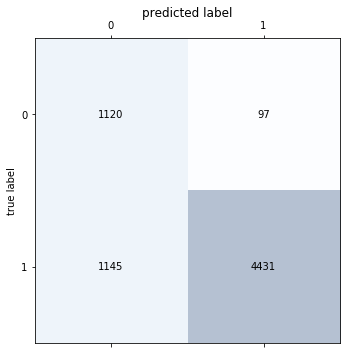


Epoch 00001: val_acc improved from -inf to 0.81716, saving model to 3_6.lstmrecall.hdf5
Epoch 2/8
15848/15848 [==============================] - 57s 4ms/step - loss: 0.2743 - acc: 0.8799 - val_loss: 0.3129 - val_acc: 0.8615
[0.8626264221944264, 0.7711298564789413, 0.8008491668080335]


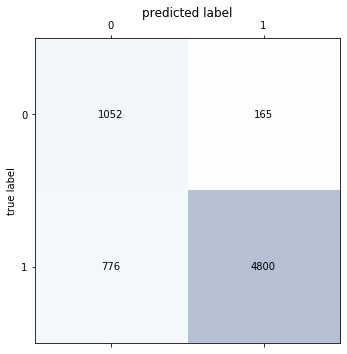


Epoch 00002: val_acc improved from 0.81716 to 0.86148, saving model to 3_6.lstmrecall.hdf5
Epoch 3/8
15848/15848 [==============================] - 57s 4ms/step - loss: 0.2228 - acc: 0.9025 - val_loss: 0.3562 - val_acc: 0.8493
[0.8542202820162476, 0.7581431412726437, 0.7870728988513989]


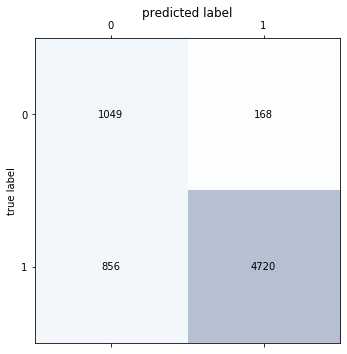


Epoch 00003: val_acc did not improve from 0.86148
Epoch 4/8
15848/15848 [==============================] - 58s 4ms/step - loss: 0.1783 - acc: 0.9213 - val_loss: 0.3504 - val_acc: 0.8675
[0.8512076053140056, 0.7760260820217041, 0.803210206533201]


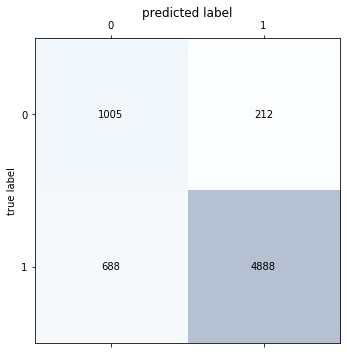


Epoch 00004: val_acc improved from 0.86148 to 0.86751, saving model to 3_6.lstmrecall.hdf5
Epoch 5/8
15848/15848 [==============================] - 58s 4ms/step - loss: 0.1388 - acc: 0.9413 - val_loss: 0.3287 - val_acc: 0.8760
[0.82493318589235, 0.7861990917924107, 0.8029731230502981]


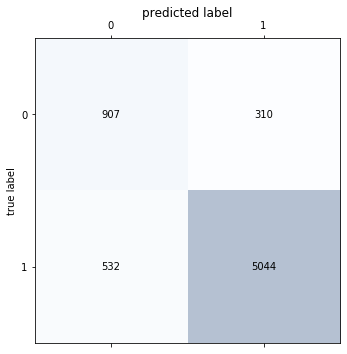


Epoch 00005: val_acc improved from 0.86751 to 0.87605, saving model to 3_6.lstmrecall.hdf5
Epoch 6/8
15848/15848 [==============================] - 58s 4ms/step - loss: 0.1108 - acc: 0.9541 - val_loss: 0.4548 - val_acc: 0.8791
[0.8136480266997073, 0.7919412686446787, 0.8020022118595962]


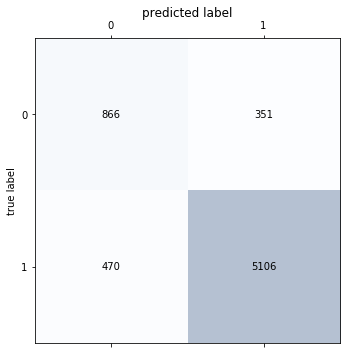


Epoch 00006: val_acc improved from 0.87605 to 0.87914, saving model to 3_6.lstmrecall.hdf5
Epoch 7/8
15848/15848 [==============================] - 58s 4ms/step - loss: 0.0816 - acc: 0.9667 - val_loss: 0.4935 - val_acc: 0.8783
[0.814073535600985, 0.7903734539895857, 0.801272141630023]


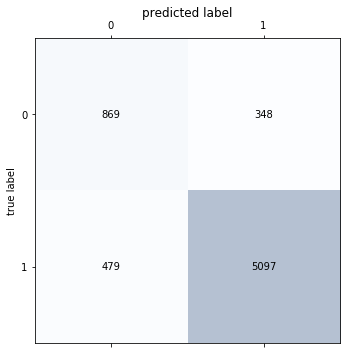


Epoch 00007: val_acc did not improve from 0.87914
Epoch 8/8
15848/15848 [==============================] - 58s 4ms/step - loss: 0.0685 - acc: 0.9720 - val_loss: 0.4895 - val_acc: 0.8662
[0.8256699978426145, 0.7721915544027411, 0.7936222063688698]


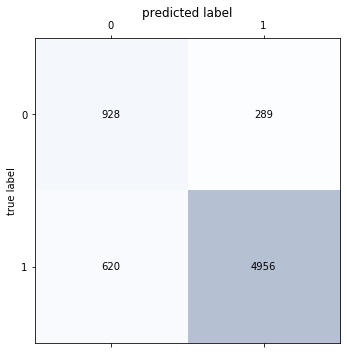


Epoch 00008: val_acc did not improve from 0.87914


In [ ]:
mc = ModelCheckpoint(filepath='3_6.lstmrecall.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(model,x_test,Y_test)
history=model.fit(x_train,Y_train,batch_size=128,epochs=8,callbacks=[Mcb,mc],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
hidden_size=64

inp=Input(shape=(max_len,))
emb=Embedding(vocab_size,embed_size,weights=[embedding_weights],mask_zero=True)(inp)
lstm1=Bidirectional(LSTM(hidden_size))(emb)
out=Dense(1,activation='sigmoid')(lstm1)

modela=Model(inputs=inp,outputs=out)
modela.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])

modela.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 300)          3828600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 4,015,609
Trainable params: 4,015,609
Non-trainable params: 0
_________________________________________________________________


Train on 15848 samples, validate on 6793 samples
Epoch 1/7
15848/15848 [==============================] - 116s 7ms/step - loss: 0.4340 - acc: 0.7679 - val_loss: 0.3294 - val_acc: 0.8551
[0.8690482541093476, 0.7664145983662102, 0.7967550929263858]


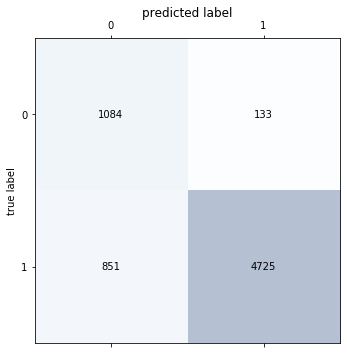


Epoch 00001: val_acc improved from -inf to 0.85515, saving model to 3_6.Mask_rnnrecall.hdf5
Epoch 2/7
15848/15848 [==============================] - 115s 7ms/step - loss: 0.2618 - acc: 0.8867 - val_loss: 0.3191 - val_acc: 0.8663
[0.8707243539338095, 0.7772804165203515, 0.8077883073799539]


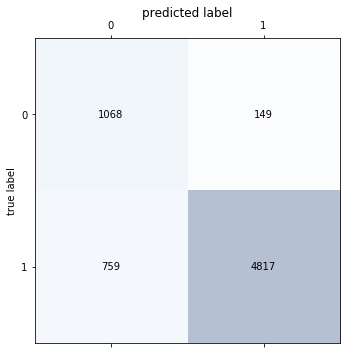


Epoch 00002: val_acc improved from 0.85515 to 0.86633, saving model to 3_6.Mask_rnnrecall.hdf5
Epoch 3/7
15848/15848 [==============================] - 115s 7ms/step - loss: 0.1972 - acc: 0.9163 - val_loss: 0.3385 - val_acc: 0.8625
[0.8626117596366161, 0.7721572629524304, 0.8018207722136235]


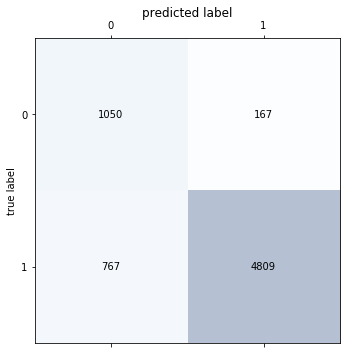


Epoch 00003: val_acc did not improve from 0.86633
Epoch 4/7
15848/15848 [==============================] - 116s 7ms/step - loss: 0.1478 - acc: 0.9362 - val_loss: 0.3299 - val_acc: 0.8784
[0.8504561308059309, 0.7896328245074327, 0.8137164169392354]


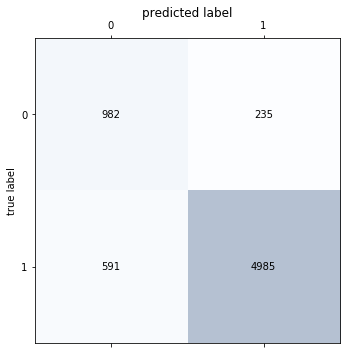


Epoch 00004: val_acc improved from 0.86633 to 0.87840, saving model to 3_6.Mask_rnnrecall.hdf5
Epoch 5/7
15848/15848 [==============================] - 118s 7ms/step - loss: 0.1112 - acc: 0.9537 - val_loss: 0.3836 - val_acc: 0.8759
[0.8402599796757791, 0.7859532404215015, 0.8079854076261108]


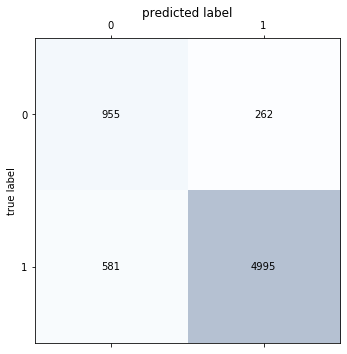


Epoch 00005: val_acc did not improve from 0.87840
Epoch 6/7
15848/15848 [==============================] - 118s 7ms/step - loss: 0.0823 - acc: 0.9658 - val_loss: 0.3911 - val_acc: 0.8758
[0.8260385511801369, 0.7857244878772476, 0.803065738962213]


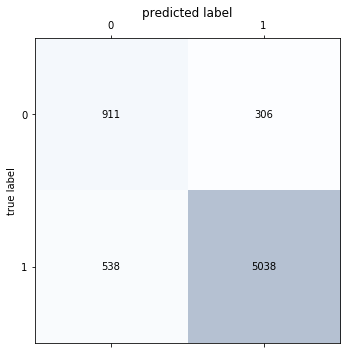


Epoch 00006: val_acc did not improve from 0.87840
Epoch 7/7
15848/15848 [==============================] - 116s 7ms/step - loss: 0.0524 - acc: 0.9803 - val_loss: 0.4965 - val_acc: 0.8662
[0.8253488215134943, 0.7721711118852861, 0.7935109841178501]


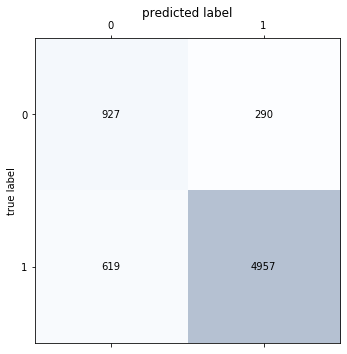


Epoch 00007: val_acc did not improve from 0.87840


In [ ]:
mc = ModelCheckpoint(filepath='3_6.Mask_rnnrecall.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(modela,x_test,Y_test)
history=modela.fit(x_train,Y_train,batch_size=128,epochs=7,callbacks=[Mcb,mc],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
hidden_size=128

inp1=Input(shape=(max_len,))
emb1=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights])(inp1)
#att=Attention(emb1)
bid_lstm=Bidirectional(LSTM(hidden_size,return_sequences=True))(emb1)
att=LSTM_Attention(bid_lstm)
flat=Flatten()(att)


out=Dense(1,activation='sigmoid')(flat)
model2=Model(inputs=inp1,outputs=out)
model2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     3828600     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 256)     439296      embedding_3[0][0]                
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 200)     0           bidirectional_1[0][0]            
____________________________________________________________________________________________

In [ ]:
plot_model(model2,show_shapes=True,to_file='BiLSTM_att.model.png')

Train on 15848 samples, validate on 6793 samples
Epoch 1/7
15848/15848 [==============================] - 85s 5ms/step - loss: 0.5965 - acc: 0.6832 - val_loss: 0.5805 - val_acc: 0.8074
[0.7982422466752097, 0.7111891886702634, 0.73357525295413]


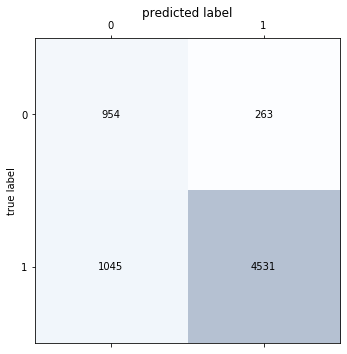


Epoch 00001: val_acc improved from -inf to 0.80745, saving model to 3_6.lstmatt.hdf5
Epoch 2/7
15848/15848 [==============================] - 83s 5ms/step - loss: 0.4819 - acc: 0.7896 - val_loss: 0.4195 - val_acc: 0.8044
[0.8143450508046577, 0.7146612564519849, 0.7366709667648892]


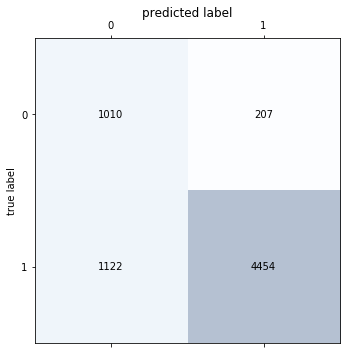


Epoch 00002: val_acc did not improve from 0.80745
Epoch 3/7
15848/15848 [==============================] - 83s 5ms/step - loss: 0.3820 - acc: 0.8069 - val_loss: 0.3910 - val_acc: 0.8303
[0.8391199105451348, 0.7392323532139105, 0.7657989161358815]


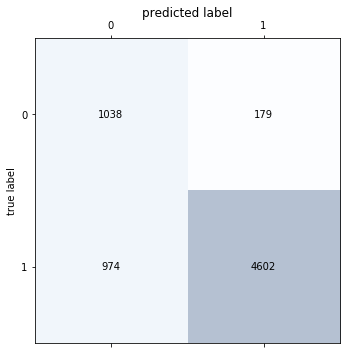


Epoch 00003: val_acc improved from 0.80745 to 0.83027, saving model to 3_6.lstmatt.hdf5
Epoch 4/7
15848/15848 [==============================] - 83s 5ms/step - loss: 0.3332 - acc: 0.8532 - val_loss: 0.3301 - val_acc: 0.8762
[0.7842334621084139, 0.7904366414016084, 0.7872696464388534]


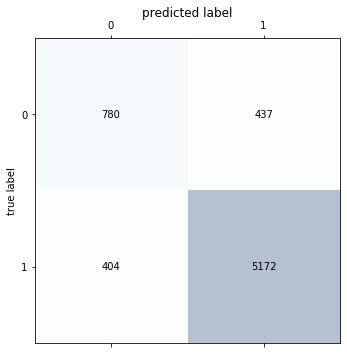


Epoch 00004: val_acc improved from 0.83027 to 0.87620, saving model to 3_6.lstmatt.hdf5
Epoch 5/7
15848/15848 [==============================] - 83s 5ms/step - loss: 0.2486 - acc: 0.8961 - val_loss: 0.3063 - val_acc: 0.8806
[0.8238588403876692, 0.793572944151099, 0.8071844500828347]


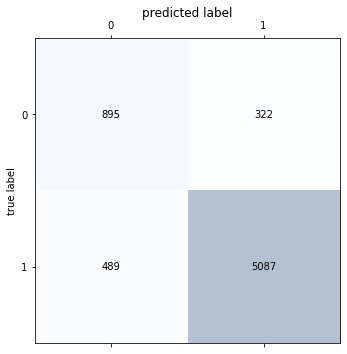


Epoch 00005: val_acc improved from 0.87620 to 0.88061, saving model to 3_6.lstmatt.hdf5
Epoch 6/7
15848/15848 [==============================] - 83s 5ms/step - loss: 0.1908 - acc: 0.9195 - val_loss: 0.4022 - val_acc: 0.8416
[0.84666685430811, 0.749947088294337, 0.7779490768926041]


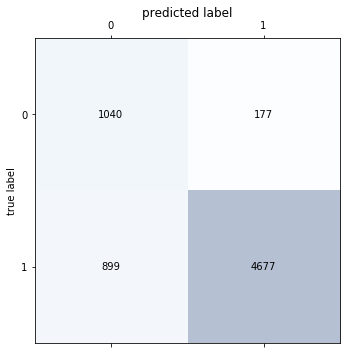


Epoch 00006: val_acc did not improve from 0.88061
Epoch 7/7
15848/15848 [==============================] - 83s 5ms/step - loss: 0.1484 - acc: 0.9363 - val_loss: 0.3597 - val_acc: 0.8793
[0.8102047570937307, 0.7925610542525336, 0.8008607277074526]


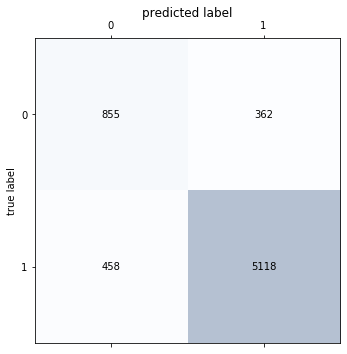


Epoch 00007: val_acc did not improve from 0.88061


In [ ]:
mc = ModelCheckpoint(filepath='3_6.lstmatt.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(model2,x_test,Y_test)
history=model2.fit(x_train,Y_train,batch_size=128,epochs=7,callbacks=[Mcb,mc],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
hidden_size=128

inp1=Input(shape=(max_len,))
emb1=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights])(inp1)
#att=Attention(emb1)
bid_lstm=Bidirectional(LSTM(hidden_size,return_sequences=True))(emb1)
att=LSTM_Attention(bid_lstm)
pool=GlobalMaxPooling1D()(att)

out=Dense(1,activation='sigmoid')(pool)
model2=Model(inputs=inp1,outputs=out)
model2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     3828600     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 256)     439296      embedding_3[0][0]                
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 200)     0           bidirectional_1[0][0]            
____________________________________________________________________________________________



Train on 15848 samples, validate on 6793 samples
Epoch 1/7
15848/15848 [==============================] - 118s 7ms/step - loss: 0.6325 - acc: 0.6538 - val_loss: 0.6115 - val_acc: 0.7144
[0.7653378459626832, 0.6614160173111274, 0.6561102291029298]


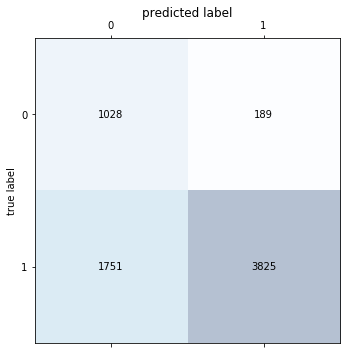


Epoch 00001: val_acc improved from -inf to 0.71441, saving model to 3_7.lstmatt.hdf5
Epoch 2/7
15848/15848 [==============================] - 116s 7ms/step - loss: 0.4208 - acc: 0.8187 - val_loss: 0.3325 - val_acc: 0.8494
[0.8562370100053168, 0.7587045815581039, 0.7878046302680102]


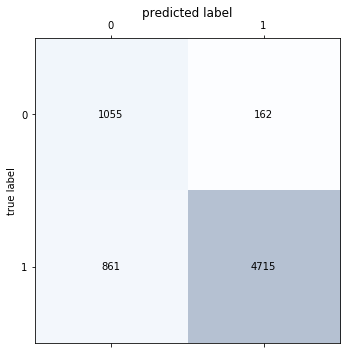


Epoch 00002: val_acc improved from 0.71441 to 0.84940, saving model to 3_7.lstmatt.hdf5
Epoch 3/7
15848/15848 [==============================] - 115s 7ms/step - loss: 0.2785 - acc: 0.8792 - val_loss: 0.3134 - val_acc: 0.8571
[0.8644327903716951, 0.7672225126483019, 0.797225432800997]


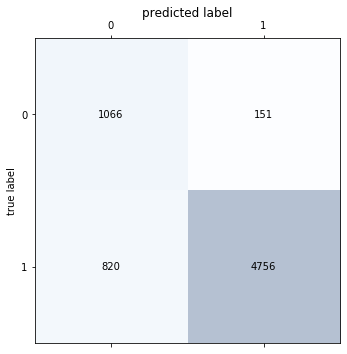


Epoch 00003: val_acc improved from 0.84940 to 0.85706, saving model to 3_7.lstmatt.hdf5
Epoch 4/7
15848/15848 [==============================] - 115s 7ms/step - loss: 0.2279 - acc: 0.9052 - val_loss: 0.2962 - val_acc: 0.8816
[0.8460053445391624, 0.794193646441306, 0.8156159032976482]


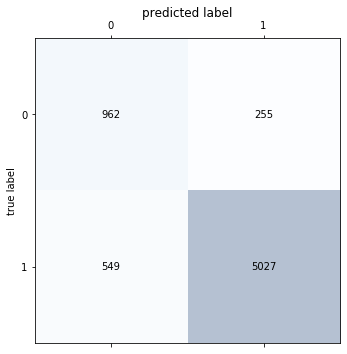


Epoch 00004: val_acc improved from 0.85706 to 0.88164, saving model to 3_7.lstmatt.hdf5
Epoch 5/7
15848/15848 [==============================] - 115s 7ms/step - loss: 0.1757 - acc: 0.9267 - val_loss: 0.3609 - val_acc: 0.8629
[0.8558148904390103, 0.7715820221332155, 0.8002387804144089]


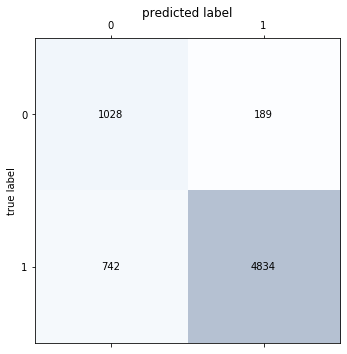


Epoch 00005: val_acc did not improve from 0.88164
Epoch 6/7
15848/15848 [==============================] - 115s 7ms/step - loss: 0.1508 - acc: 0.9360 - val_loss: 0.3550 - val_acc: 0.8635
[0.8555312178381584, 0.7721641148376095, 0.8007133179166582]


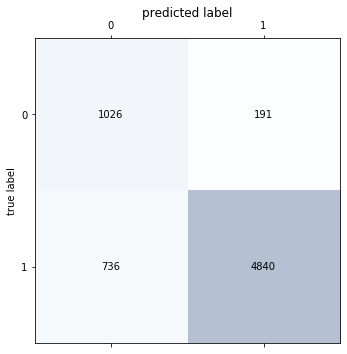


Epoch 00006: val_acc did not improve from 0.88164
Epoch 7/7
15848/15848 [==============================] - 114s 7ms/step - loss: 0.1255 - acc: 0.9481 - val_loss: 0.3673 - val_acc: 0.8768
[0.8183156567234385, 0.7876216517069521, 0.8013524302227362]


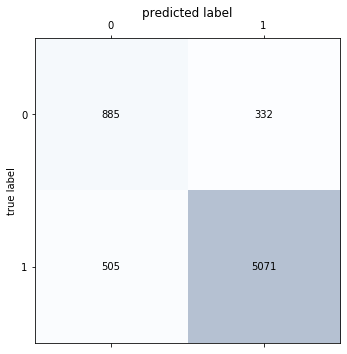


Epoch 00007: val_acc did not improve from 0.88164


In [ ]:
mc = ModelCheckpoint(filepath='3_7.lstmatt.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(model2,x_test,Y_test)
history=model2.fit(x_train,Y_train,batch_size=128,epochs=7,callbacks=[Mcb,mc],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
hidden_size=128

inp1=Input(shape=(max_len,))
emb1=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights])(inp1)
#att=Attention(emb1)
bid_lstm=Bidirectional(LSTM(hidden_size,return_sequences=True))(emb1)
att=LSTM_Attention1(bid_lstm)

pool=GlobalMaxPooling1D()(att)

out=Dense(1,activation='sigmoid')(pool)
model2=Model(inputs=inp1,outputs=out)
model2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 300)     3828600     input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200, 256)     439296      embedding_5[0][0]                
__________________________________________________________________________________________________
permute_5 (Permute)             (None, 256, 200)     0           bidirectional_3[0][0]            
____________________________________________________________________________________________



Train on 15848 samples, validate on 6793 samples
Epoch 1/9
15848/15848 [==============================] - 115s 7ms/step - loss: 0.5984 - acc: 0.6203 - val_loss: 0.5197 - val_acc: 0.7702
[0.809921600261244, 0.6970993634529673, 0.7092658686078201]


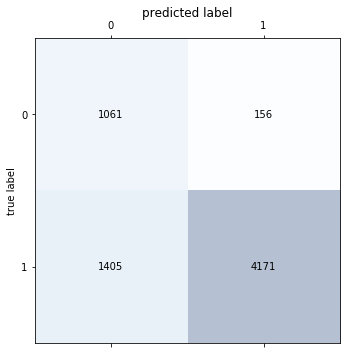


Epoch 00001: val_acc improved from -inf to 0.77020, saving model to 3_9.lstmattave.hdf5
Epoch 2/9
15848/15848 [==============================] - 113s 7ms/step - loss: 0.3456 - acc: 0.8482 - val_loss: 0.4386 - val_acc: 0.8105
[0.8550464692560793, 0.7321729707748406, 0.7540299352511118]


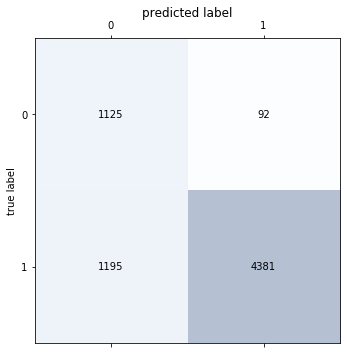


Epoch 00002: val_acc improved from 0.77020 to 0.81054, saving model to 3_9.lstmattave.hdf5
Epoch 3/9
15848/15848 [==============================] - 114s 7ms/step - loss: 0.2534 - acc: 0.8951 - val_loss: 0.2974 - val_acc: 0.8787
[0.8509566471637455, 0.7900464739022732, 0.814167466777155]


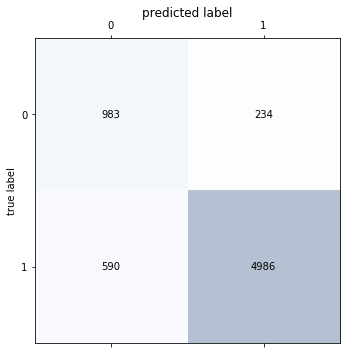


Epoch 00003: val_acc improved from 0.81054 to 0.87870, saving model to 3_9.lstmattave.hdf5
Epoch 4/9
15848/15848 [==============================] - 112s 7ms/step - loss: 0.1996 - acc: 0.9156 - val_loss: 0.3165 - val_acc: 0.8730
[0.8481018692624454, 0.782358052180532, 0.8075596270115509]


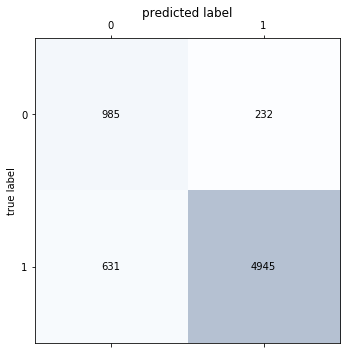


Epoch 00004: val_acc did not improve from 0.87870
Epoch 5/9
15848/15848 [==============================] - 114s 7ms/step - loss: 0.1584 - acc: 0.9355 - val_loss: 0.3241 - val_acc: 0.8760
[0.837137886398923, 0.7861138520066482, 0.807112895475985]


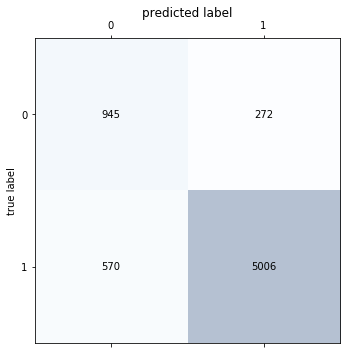


Epoch 00005: val_acc did not improve from 0.87870
Epoch 6/9
15848/15848 [==============================] - 113s 7ms/step - loss: 0.1264 - acc: 0.9491 - val_loss: 0.3713 - val_acc: 0.8803
[0.8236795003589747, 0.7930953568552976, 0.8068222922241193]


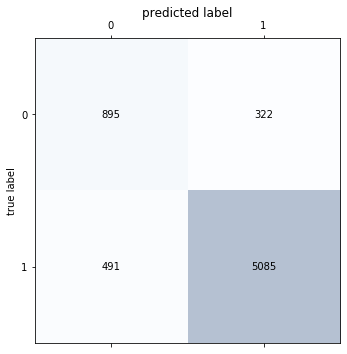


Epoch 00006: val_acc improved from 0.87870 to 0.88032, saving model to 3_9.lstmattave.hdf5
Epoch 7/9
15848/15848 [==============================] - 113s 7ms/step - loss: 0.1070 - acc: 0.9548 - val_loss: 0.3908 - val_acc: 0.8693
[0.8269107154856652, 0.7763961446311523, 0.7970194535036631]


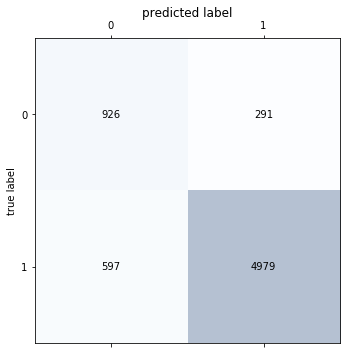


Epoch 00007: val_acc did not improve from 0.88032
Epoch 8/9
15848/15848 [==============================] - 112s 7ms/step - loss: 0.0940 - acc: 0.9624 - val_loss: 0.3523 - val_acc: 0.8864
[0.7945959853769353, 0.8099933446344294, 0.8019236109411434]


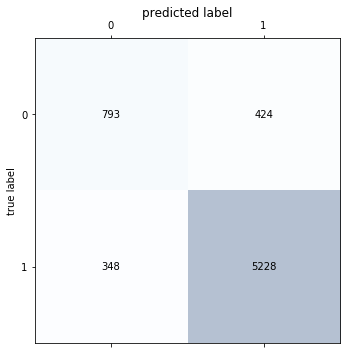


Epoch 00008: val_acc improved from 0.88032 to 0.88635, saving model to 3_9.lstmattave.hdf5
Epoch 9/9
15848/15848 [==============================] - 112s 7ms/step - loss: 0.0922 - acc: 0.9631 - val_loss: 0.3631 - val_acc: 0.8750
[0.8137066769309483, 0.7849836812611614, 0.7979126254058868]


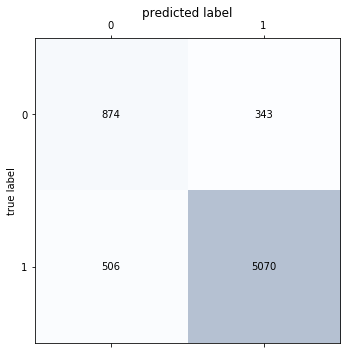


Epoch 00009: val_acc did not improve from 0.88635


In [ ]:
mc = ModelCheckpoint(filepath='3_9.lstmattave.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(model2,x_test,Y_test)
history=model2.fit(x_train,Y_train,batch_size=128,epochs=9,callbacks=[Mcb,mc],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
inp=Input(shape=(max_len,))
emb1=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights])(inp)
emb2=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights],trainable=False)(inp)
conv1=Conv1D(128,3,padding='same',strides=1,activation='relu')(emb1)
att1=Attention(conv1)
conv1=Conv1D(128,4,padding='same',strides=1,activation='relu')(emb1)
att2=Attention(conv1)
conv1=Conv1D(128,5,padding='same',strides=1,activation='relu')(emb1)
att3=Attention(conv1)
conv2=Conv1D(128,3,padding='same',strides=1,activation='relu')(emb2)
att4=Attention(conv2)
conv2=Conv1D(128,4,padding='same',strides=1,activation='relu')(emb2)
att5=Attention(conv2)
conv2=Conv1D(128,5,padding='same',strides=1,activation='relu')(emb2)
att6=Attention(conv2)



conv=Concatenate()([att1,att2,att3,att4,att5,att6])
pool=GlobalMaxPooling1D()(conv)

out=Dense(1,activation='sigmoid')(pool)

model=Model(inputs=inp,outputs=out)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     3828600     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 300)     3828600     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 128)     115328      embedding_4[0][0]                
____________________________________________________________________________________________

In [ ]:
plot_model(model,show_shapes=True,to_file='CNN_att.model.png')

Train on 15848 samples, validate on 6793 samples
Epoch 1/8
15848/15848 [==============================] - 14s 912us/step - loss: 0.5665 - acc: 0.6660 - val_loss: 0.3230 - val_acc: 0.8647

Epoch 00001: val_acc improved from -inf to 0.86471, saving model to 3_6.cnnattrecall.hdf5
[0.8273427083321053, 0.7704107730696631, 0.7927976661568008]


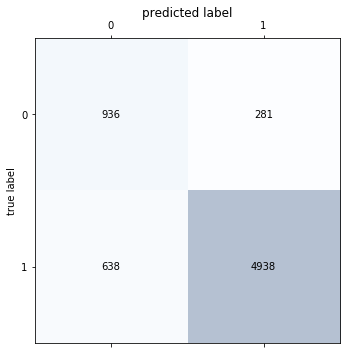

Epoch 2/8
15848/15848 [==============================] - 7s 463us/step - loss: 0.3100 - acc: 0.8667 - val_loss: 0.4053 - val_acc: 0.8323

Epoch 00002: val_acc did not improve from 0.86471
[0.857718812518494, 0.7459245035519838, 0.7731281207346399]


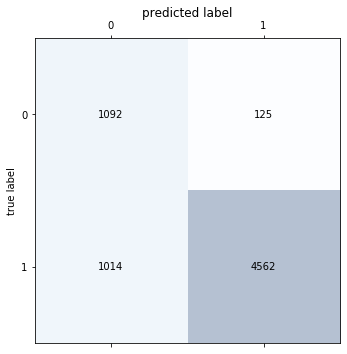

Epoch 3/8
15848/15848 [==============================] - 7s 465us/step - loss: 0.2176 - acc: 0.9096 - val_loss: 0.3078 - val_acc: 0.8758

Epoch 00003: val_acc improved from 0.86471 to 0.87575, saving model to 3_6.cnnattrecall.hdf5
[0.83824325168671, 0.7857109426540697, 0.80718220955176]


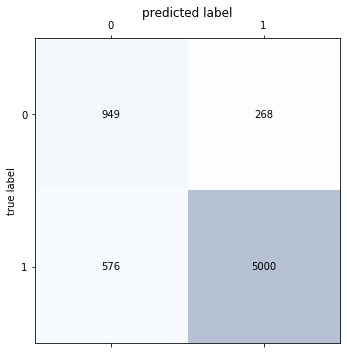

Epoch 4/8
15848/15848 [==============================] - 7s 461us/step - loss: 0.1433 - acc: 0.9384 - val_loss: 0.3232 - val_acc: 0.8846

Epoch 00004: val_acc improved from 0.87575 to 0.88459, saving model to 3_6.cnnattrecall.hdf5
[0.799301119128935, 0.8048187675629986, 0.8020113699055879]


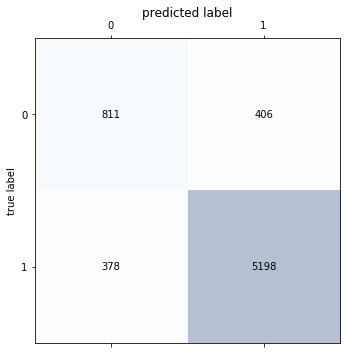

Epoch 5/8
15848/15848 [==============================] - 7s 464us/step - loss: 0.0873 - acc: 0.9645 - val_loss: 0.4623 - val_acc: 0.8613

Epoch 00005: val_acc did not improve from 0.88459
[0.8243167690147586, 0.7659146230804716, 0.7885648273707283]


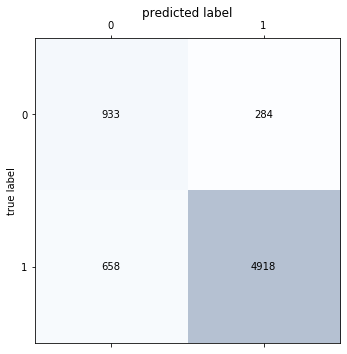

Epoch 6/8
15848/15848 [==============================] - 7s 463us/step - loss: 0.0459 - acc: 0.9832 - val_loss: 0.5102 - val_acc: 0.8703

Epoch 00006: val_acc did not improve from 0.88459
[0.7967054779905429, 0.7780628690465734, 0.7867607542326667]


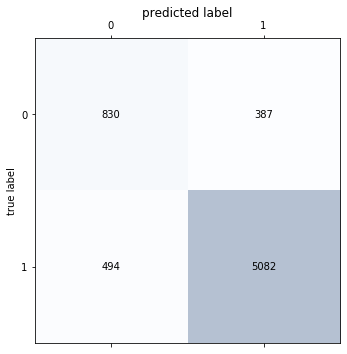

Epoch 7/8
15848/15848 [==============================] - 7s 461us/step - loss: 0.0226 - acc: 0.9926 - val_loss: 0.5922 - val_acc: 0.8774

Epoch 00007: val_acc did not improve from 0.88459
[0.7762790613369424, 0.7946516048910066, 0.7849003523166485]


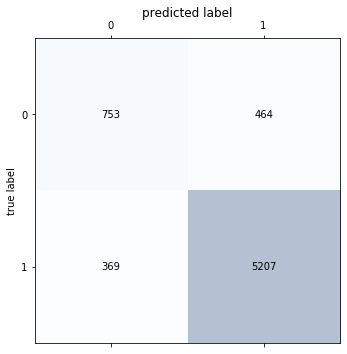

Epoch 8/8
15848/15848 [==============================] - 7s 464us/step - loss: 0.0104 - acc: 0.9967 - val_loss: 0.6761 - val_acc: 0.8744

Epoch 00008: val_acc did not improve from 0.88459
[0.7696680161131932, 0.789676461611911, 0.7789866582895817]


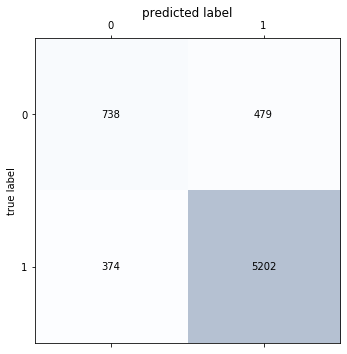

In [ ]:
mc = ModelCheckpoint(filepath='3_6.cnnattrecall.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(model,x_test,Y_test)
history=model.fit(x_train,Y_train,batch_size=128,epochs=8,callbacks=[mc,Mcb],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
inp=Input(shape=(max_len,))
emb1=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights])(inp)
emb2=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights],trainable=False)(inp)

conv1=Conv1D(128,3,padding='same',strides=1,activation='relu')(emb1)
pool1=MaxPool1D()(conv1)
conv1=Conv1D(128,4,padding='same',strides=1,activation='relu')(emb1)
pool2=MaxPool1D()(conv1)
conv1=Conv1D(128,5,padding='same',strides=1,activation='relu')(emb1)
pool3=MaxPool1D()(conv1)
conv2=Conv1D(128,3,padding='same',strides=1,activation='relu')(emb2)
pool4=MaxPool1D()(conv2)
conv2=Conv1D(128,4,padding='same',strides=1,activation='relu')(emb2)
pool5=MaxPool1D()(conv2)
conv2=Conv1D(128,5,padding='same',strides=1,activation='relu')(emb2)
pool6=MaxPool1D()(conv2)



conv=Concatenate()([pool1,pool2,pool3,pool4,pool5,pool6])
pool=GlobalMaxPooling1D()(conv)

out=Dense(1,activation='sigmoid')(pool)

model=Model(inputs=inp,outputs=out)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     3828600     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 300)     3828600     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 200, 128)     115328      embedding_3[0][0]                
____________________________________________________________________________________________

In [ ]:
plot_model(model,show_shapes=True,to_file='CNN.model.png')



Train on 15848 samples, validate on 6793 samples
Epoch 1/8
15848/15848 [==============================] - 12s 761us/step - loss: 0.4030 - acc: 0.8109 - val_loss: 0.4397 - val_acc: 0.8166

Epoch 00001: val_acc improved from -inf to 0.81658, saving model to 3_9.cnnpoolrecall.hdf5
[0.8625770557937587, 0.737943246293447, 0.761119847641927]


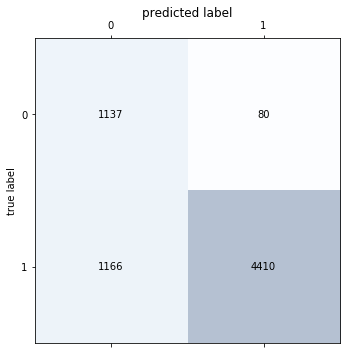

Epoch 2/8
15848/15848 [==============================] - 5s 301us/step - loss: 0.2234 - acc: 0.9102 - val_loss: 0.3227 - val_acc: 0.8722

Epoch 00002: val_acc improved from 0.81658 to 0.87222, saving model to 3_9.cnnpoolrecall.hdf5
[0.8800923284318638, 0.7846815947798695, 0.8160837982971842]


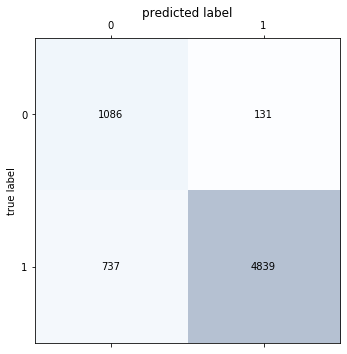

Epoch 3/8
15848/15848 [==============================] - 5s 299us/step - loss: 0.1367 - acc: 0.9501 - val_loss: 0.2489 - val_acc: 0.8968

Epoch 00003: val_acc improved from 0.87222 to 0.89681, saving model to 3_9.cnnpoolrecall.hdf5
[0.8594166482954888, 0.8173793196601189, 0.8357327005347086]


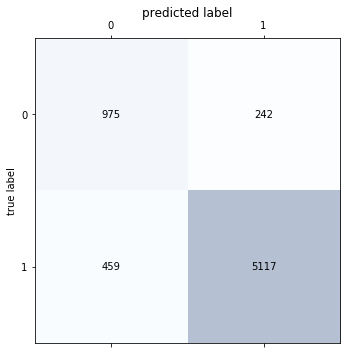

Epoch 4/8
15848/15848 [==============================] - 5s 301us/step - loss: 0.0764 - acc: 0.9761 - val_loss: 0.2515 - val_acc: 0.9005

Epoch 00004: val_acc improved from 0.89681 to 0.90049, saving model to 3_9.cnnpoolrecall.hdf5
[0.855234872071762, 0.8246428232825027, 0.838568937636223]


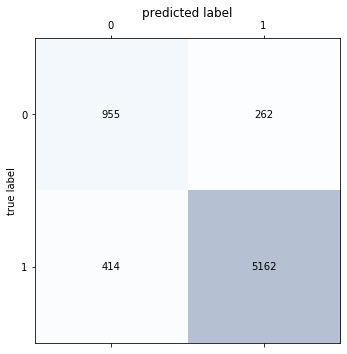

Epoch 5/8
15848/15848 [==============================] - 5s 299us/step - loss: 0.0429 - acc: 0.9876 - val_loss: 0.2553 - val_acc: 0.9023

Epoch 00005: val_acc improved from 0.90049 to 0.90225, saving model to 3_9.cnnpoolrecall.hdf5
[0.82965327692694, 0.8352863511921944, 0.8324250470638517]


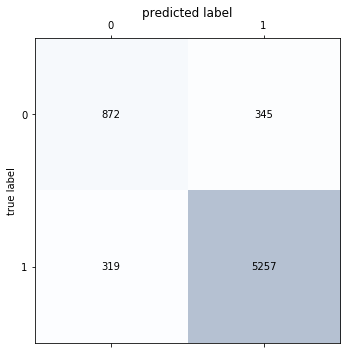

Epoch 6/8
15848/15848 [==============================] - 5s 302us/step - loss: 0.0209 - acc: 0.9962 - val_loss: 0.2736 - val_acc: 0.9024

Epoch 00006: val_acc improved from 0.90225 to 0.90240, saving model to 3_9.cnnpoolrecall.hdf5
[0.817217070105594, 0.8407534929634184, 0.8282158903235555]


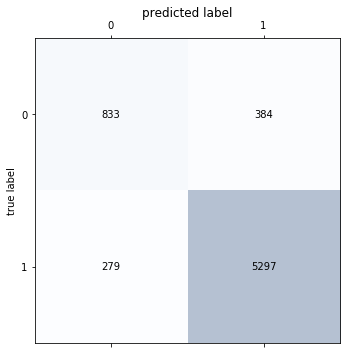

Epoch 7/8
15848/15848 [==============================] - 5s 300us/step - loss: 0.0112 - acc: 0.9991 - val_loss: 0.2948 - val_acc: 0.8981

Epoch 00007: val_acc did not improve from 0.90240
[0.8326025141202642, 0.8251457152653128, 0.8287927239140285]


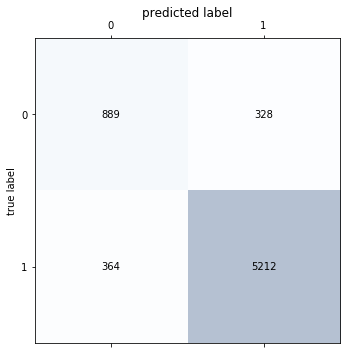

Epoch 8/8
15848/15848 [==============================] - 5s 298us/step - loss: 0.0067 - acc: 0.9998 - val_loss: 0.3077 - val_acc: 0.8984

Epoch 00008: val_acc did not improve from 0.90240
[0.8202559773132654, 0.8296675950281087, 0.8248339589303413]


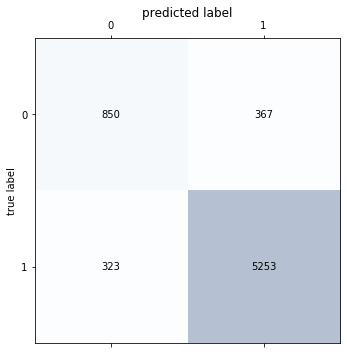

In [ ]:
mc = ModelCheckpoint(filepath='3_9.cnnpoolrecall.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(model,x_test,Y_test)
history=model.fit(x_train,Y_train,batch_size=128,epochs=8,callbacks=[mc,Mcb],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
hidden_size=128
inp=Input((max_len,))
emb=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights])(inp)
bilstm=Bidirectional(LSTM(hidden_size,return_sequences=True))(emb)

cnn1=Conv1D(128,3,padding='same',strides=1,activation='relu')(bilstm)
att1=Attention(cnn1)
cnn2=Conv1D(128,4,padding='same',strides=1,activation='relu')(bilstm)
att2=Attention(cnn2)
cnn3=Conv1D(128,5,padding='same',strides=1,activation='relu')(bilstm)
att3=Attention(cnn3)
cnn=Concatenate()([att1,att2,att3])
pool=GlobalMaxPooling1D()(cnn)

out=Dense(1,activation='sigmoid')(pool)
modelb=Model(inputs=inp,outputs=out)
modelb.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelb.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 200, 300)     3828600     input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 200, 256)     439296      embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 200, 128)     98432       bidirectional_4[0][0]            
____________________________________________________________________________________________

In [ ]:
plot_model(modelb,show_shapes=True,to_file='BiLSTMCNN_att.model.png')

Train on 15848 samples, validate on 6793 samples
Epoch 1/7
15848/15848 [==============================] - 89s 6ms/step - loss: 0.4935 - acc: 0.8075 - val_loss: 0.4232 - val_acc: 0.8089

Epoch 00001: val_acc improved from -inf to 0.80892, saving model to 3_6.bilstmcnnattrecall.hdf5
[0.8566295097312228, 0.7319252705524093, 0.7531437011414395]


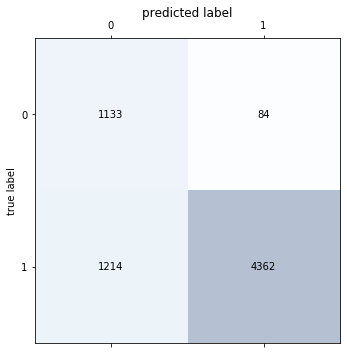

Epoch 2/7
15848/15848 [==============================] - 85s 5ms/step - loss: 0.2937 - acc: 0.8655 - val_loss: 0.3324 - val_acc: 0.8644

Epoch 00002: val_acc improved from 0.80892 to 0.86442, saving model to 3_6.bilstmcnnattrecall.hdf5
[0.8576751195698433, 0.7734025052936115, 0.8021941051162029]


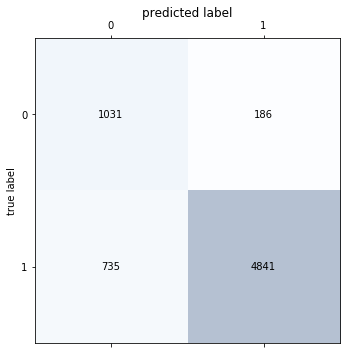

Epoch 3/7
15848/15848 [==============================] - 85s 5ms/step - loss: 0.2182 - acc: 0.9033 - val_loss: 0.3205 - val_acc: 0.8703

Epoch 00003: val_acc improved from 0.86442 to 0.87031, saving model to 3_6.bilstmcnnattrecall.hdf5
[0.8487360433080381, 0.7791049845735798, 0.8051602333857983]


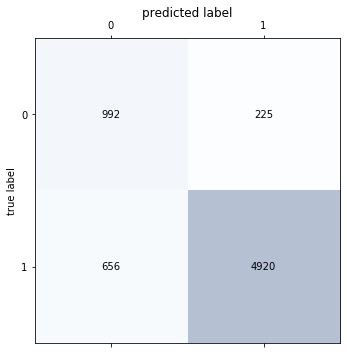

Epoch 4/7
15848/15848 [==============================] - 86s 5ms/step - loss: 0.1852 - acc: 0.9166 - val_loss: 0.3254 - val_acc: 0.8710

Epoch 00004: val_acc improved from 0.87031 to 0.87104, saving model to 3_6.bilstmcnnattrecall.hdf5
[0.8527173330000979, 0.7803353665678159, 0.8071029242896219]


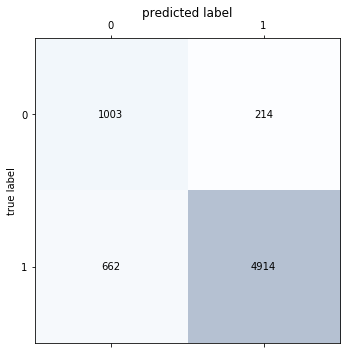

Epoch 5/7
15848/15848 [==============================] - 86s 5ms/step - loss: 0.1368 - acc: 0.9390 - val_loss: 0.3287 - val_acc: 0.8816

Epoch 00005: val_acc improved from 0.87104 to 0.88164, saving model to 3_6.bilstmcnnattrecall.hdf5
[0.8093912430194437, 0.7969908746656331, 0.8029380479884539]


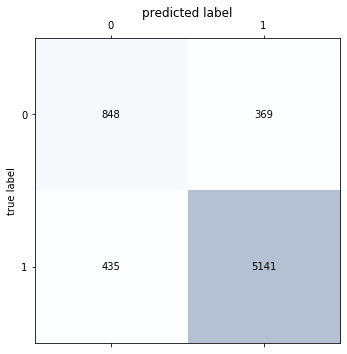

Epoch 6/7
15848/15848 [==============================] - 86s 5ms/step - loss: 0.1088 - acc: 0.9512 - val_loss: 0.4279 - val_acc: 0.8528

Epoch 00006: val_acc did not improve from 0.88164
[0.8415982512210447, 0.7589413097805713, 0.7864070221246229]


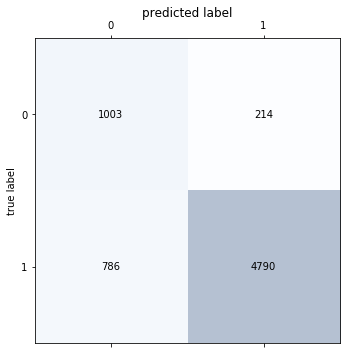

Epoch 7/7
15848/15848 [==============================] - 87s 6ms/step - loss: 0.0864 - acc: 0.9610 - val_loss: 0.5234 - val_acc: 0.8619

Epoch 00007: val_acc did not improve from 0.88164
[0.8275660360342305, 0.7669544743801295, 0.7902346483448384]


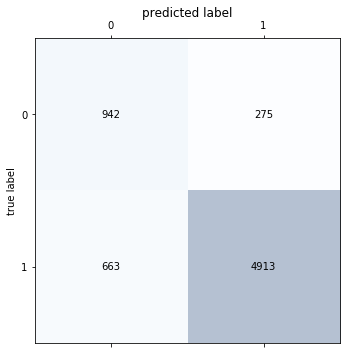

In [ ]:
mc = ModelCheckpoint(filepath='3_6.bilstmcnnattrecall.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(modelb,x_test,Y_test)
history=modelb.fit(x_train,Y_train,batch_size=128,epochs=7,callbacks=[mc,Mcb],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
hidden_size=128
inp=Input((max_len,))
emb=Embedding(vocab_size,embed_size,input_length=max_len,weights=[embedding_weights])(inp)
bilstm =Bidirectional(LSTM(128,return_sequences=True))(emb)

cnn1=Conv1D(128,3,padding='same',strides=1,activation='relu')(bilstm)
pool1=MaxPool1D()(cnn1)
cnn2=Conv1D(128,4,padding='same',strides=1,activation='relu')(bilstm)
pool2=MaxPool1D()(cnn2)
cnn3=Conv1D(128,5,padding='same',strides=1,activation='relu')(bilstm)
pool3=MaxPool1D()(cnn3)
cnn4=Conv1D(128,6,padding='same',strides=1,activation='relu')(bilstm)
cnn=Concatenate()([pool1,pool2,pool3])

pool=GlobalMaxPooling1D()(cnn)

out=Dense(1,activation='sigmoid')(pool)

modelb=Model(inputs=inp,outputs=out)
modelb.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelb.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 300)     3828600     input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 200, 256)     439296      embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 200, 128)     98432       bidirectional_5[0][0]            
____________________________________________________________________________________________

In [ ]:
plot_model(modelb,show_shapes=True,to_file='BiLSTMCNN.model.png')



Train on 15848 samples, validate on 6793 samples
Epoch 1/10
15848/15848 [==============================] - 92s 6ms/step - loss: 0.4032 - acc: 0.8110 - val_loss: 0.3365 - val_acc: 0.8574

Epoch 00001: val_acc improved from -inf to 0.85735, saving model to 3_9.bilstmcnnrecall.hdf5
[0.8626850724256674, 0.7671676158518264, 0.7969970794041787]


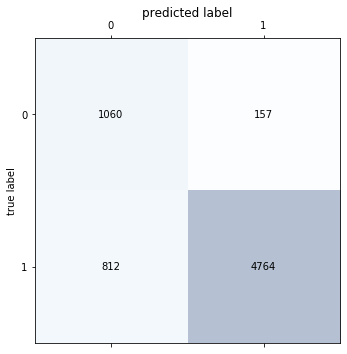

Epoch 2/10
15848/15848 [==============================] - 85s 5ms/step - loss: 0.2406 - acc: 0.8956 - val_loss: 0.2520 - val_acc: 0.8939

Epoch 00002: val_acc improved from 0.85735 to 0.89386, saving model to 3_9.bilstmcnnrecall.hdf5
[0.8338561996536394, 0.8161510667982879, 0.8245284483716991]


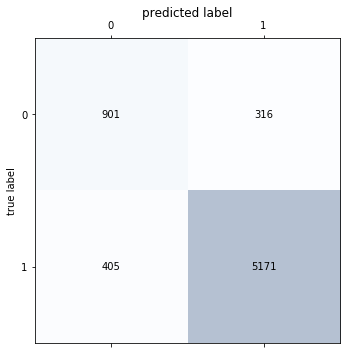

Epoch 3/10
15848/15848 [==============================] - 84s 5ms/step - loss: 0.1746 - acc: 0.9259 - val_loss: 0.3089 - val_acc: 0.8797

Epoch 00003: val_acc did not improve from 0.89386
[0.8608984508086659, 0.7917466003752953, 0.8181949185536719]


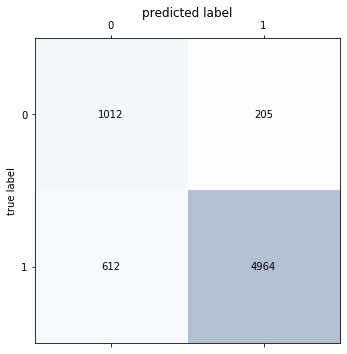

Epoch 4/10
15848/15848 [==============================] - 84s 5ms/step - loss: 0.1124 - acc: 0.9542 - val_loss: 0.3509 - val_acc: 0.8784

Epoch 00004: val_acc did not improve from 0.89386
[0.844032604223524, 0.7895243179828314, 0.8117044867277425]


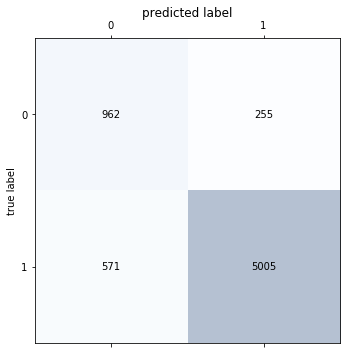

Epoch 5/10
15848/15848 [==============================] - 84s 5ms/step - loss: 0.0668 - acc: 0.9743 - val_loss: 0.4230 - val_acc: 0.8730

Epoch 00005: val_acc did not improve from 0.89386
[0.8288312895152249, 0.7815949826306687, 0.8012655173836427]


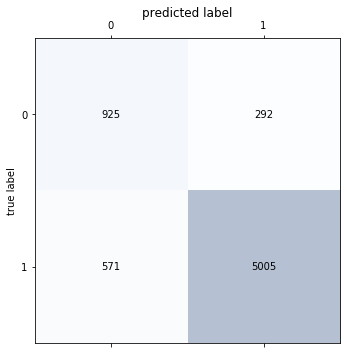

Epoch 6/10
15848/15848 [==============================] - 83s 5ms/step - loss: 0.0428 - acc: 0.9834 - val_loss: 0.5436 - val_acc: 0.8839

Epoch 00006: val_acc did not improve from 0.89386
[0.8113786458928923, 0.8008827643793452, 0.8059524628017236]


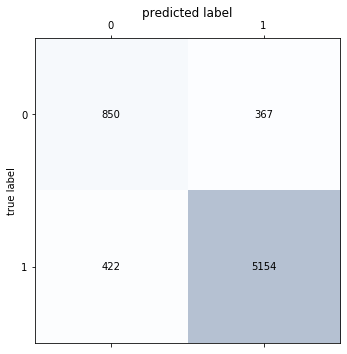

Epoch 7/10
15848/15848 [==============================] - 83s 5ms/step - loss: 0.0345 - acc: 0.9860 - val_loss: 0.5405 - val_acc: 0.8839

Epoch 00007: val_acc did not improve from 0.89386
[0.7693045467781277, 0.8128833573310643, 0.7881256899918894]


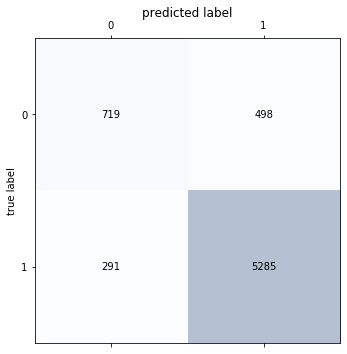

Epoch 8/10
15848/15848 [==============================] - 83s 5ms/step - loss: 0.0293 - acc: 0.9891 - val_loss: 0.5922 - val_acc: 0.8812

Epoch 00008: val_acc did not improve from 0.89386
[0.796917532469829, 0.7982608064919627, 0.7975862106016517]


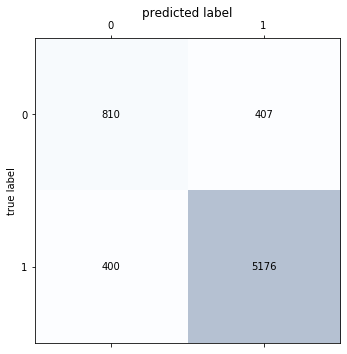

Epoch 9/10
15848/15848 [==============================] - 83s 5ms/step - loss: 0.0148 - acc: 0.9944 - val_loss: 0.7393 - val_acc: 0.8819

Epoch 00009: val_acc did not improve from 0.89386
[0.7989717641871668, 0.7993565255626529, 0.7991639033200268]


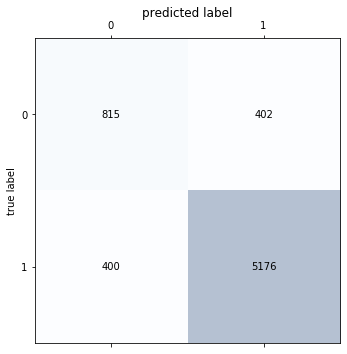

Epoch 10/10
15848/15848 [==============================] - 83s 5ms/step - loss: 0.0039 - acc: 0.9986 - val_loss: 0.7794 - val_acc: 0.8831

Epoch 00010: val_acc did not improve from 0.89386
[0.8083608851881936, 0.7999683049468366, 0.8040501461474587]


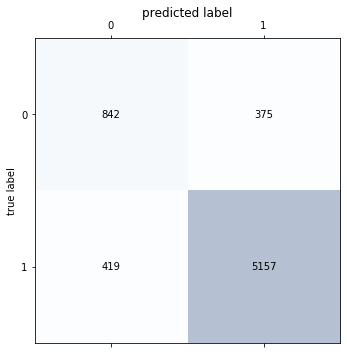

In [ ]:
mc = ModelCheckpoint(filepath='3_9.bilstmcnnrecall.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(modelb,x_test,Y_test)
history=modelb.fit(x_train,Y_train,batch_size=128,epochs=10,callbacks=[mc,Mcb],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)



Train on 15848 samples, validate on 6793 samples
Epoch 1/10
15848/15848 [==============================] - 144s 9ms/step - loss: 0.4391 - acc: 0.7814 - val_loss: 0.3455 - val_acc: 0.8540

Epoch 00001: val_acc improved from -inf to 0.85397, saving model to 3_9.hdf5
[0.8689732466528106, 0.7653742988196706, 0.79564477652423]


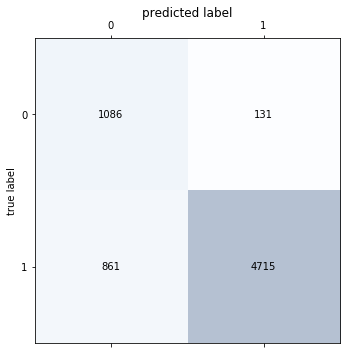

Epoch 2/10
15848/15848 [==============================] - 133s 8ms/step - loss: 0.2490 - acc: 0.8947 - val_loss: 0.2922 - val_acc: 0.8827

Epoch 00002: val_acc improved from 0.85397 to 0.88267, saving model to 3_9.hdf5
[0.8598012641335269, 0.7956550269050466, 0.8208745753355966]


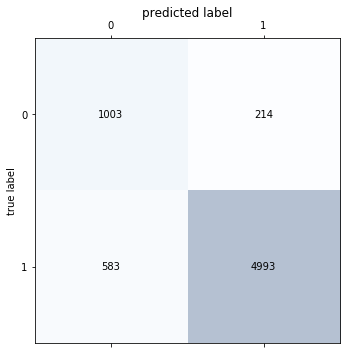

Epoch 3/10
15848/15848 [==============================] - 130s 8ms/step - loss: 0.1679 - acc: 0.9310 - val_loss: 0.3419 - val_acc: 0.8774

Epoch 00003: val_acc did not improve from 0.88267
[0.8546460856423055, 0.7884040994028495, 0.813958899440496]


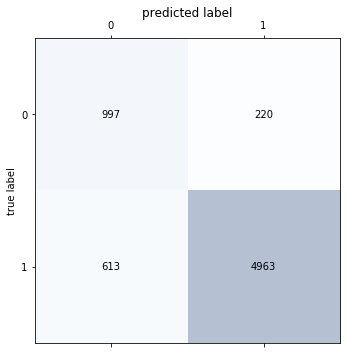

Epoch 4/10
15848/15848 [==============================] - 131s 8ms/step - loss: 0.1038 - acc: 0.9591 - val_loss: 0.3679 - val_acc: 0.8752

Epoch 00004: val_acc did not improve from 0.88267
[0.8520163301106161, 0.7854117620070369, 0.8109536201566018]


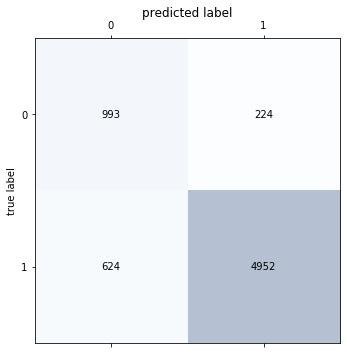

Epoch 5/10
15848/15848 [==============================] - 133s 8ms/step - loss: 0.0623 - acc: 0.9753 - val_loss: 0.4031 - val_acc: 0.8825

Epoch 00005: val_acc did not improve from 0.88267
[0.8041480891813606, 0.7995554302215142, 0.8018174051601046]


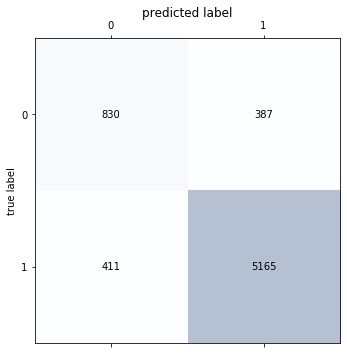

Epoch 6/10
15848/15848 [==============================] - 135s 9ms/step - loss: 0.0336 - acc: 0.9885 - val_loss: 0.5551 - val_acc: 0.8684

Epoch 00006: val_acc did not improve from 0.88267
[0.8353656326149514, 0.7756967562643252, 0.7990207953411828]


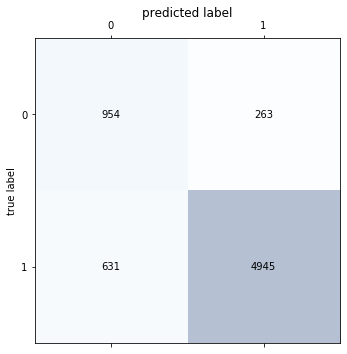

Epoch 7/10
15848/15848 [==============================] - 134s 8ms/step - loss: 0.0187 - acc: 0.9926 - val_loss: 0.6236 - val_acc: 0.8902

Epoch 00007: val_acc improved from 0.88267 to 0.89018, saving model to 3_9.hdf5
[0.7802262366357049, 0.8253066151270647, 0.7997449894932447]


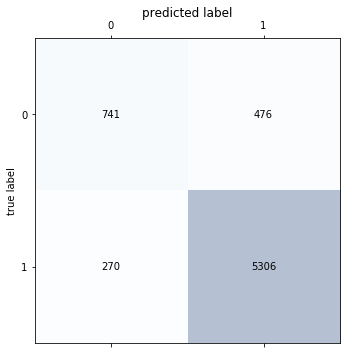

Epoch 8/10
15848/15848 [==============================] - 133s 8ms/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.8316 - val_acc: 0.8872

Epoch 00008: val_acc did not improve from 0.89018
[0.7999516503998236, 0.8104449396182789, 0.8050265273497441]


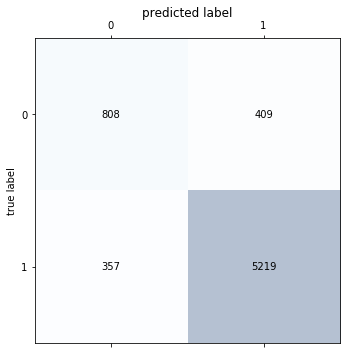

Epoch 9/10
15848/15848 [==============================] - 133s 8ms/step - loss: 0.0097 - acc: 0.9965 - val_loss: 0.7511 - val_acc: 0.8766

Epoch 00009: val_acc did not improve from 0.89018
[0.8060212862025183, 0.7882817825050634, 0.7966133366260875]


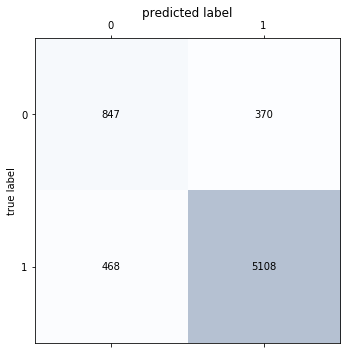

Epoch 10/10
15848/15848 [==============================] - 131s 8ms/step - loss: 0.0143 - acc: 0.9948 - val_loss: 0.6492 - val_acc: 0.8775

Epoch 00010: val_acc did not improve from 0.89018
[0.8174793014786932, 0.7888791273388835, 0.8017842092209208]


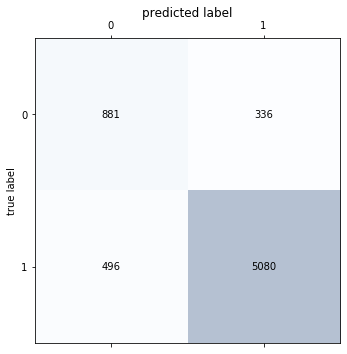

In [ ]:
mc = ModelCheckpoint(filepath='3_9.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
Mcb = MCallback(modelb,x_test,Y_test)
history=modelb.fit(x_train,Y_train,batch_size=128,epochs=10,callbacks=[mc,Mcb],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

In [ ]:
inp = Input(shape=(max_len,))
emb=Embedding(vocab_size,embed_size,weights=[embedding_weights])(inp)
dense=Dense(256)(emb)
pool = GlobalMaxPooling1D()(dense)
drop = Dropout(0.2)(pool)
pred = Dense(1,activation='sigmoid')(drop)
model = Model(inputs=inp,outputs=pred)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 200, 300)          3828600   
_________________________________________________________________
dense_16 (Dense)             (None, 200, 256)          77056     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 3,905,913
Trainable params: 3,905,913
Non-trainable params: 0
_________________________________________________

Train on 15848 samples, validate on 6793 samples
Epoch 1/5
15848/15848 [==============================] - 145s 9ms/step - loss: 0.3970 - acc: 0.8185 - val_loss: 0.3112 - val_acc: 0.8721
[0.859768549682935, 0.7821984763001211, 0.8102255628462258]


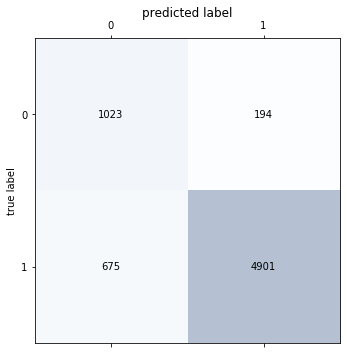

Epoch 2/5
15848/15848 [==============================] - 140s 9ms/step - loss: 0.2633 - acc: 0.8888 - val_loss: 0.4098 - val_acc: 0.8326
[0.8559710945724663, 0.745627023744592, 0.7728781298379406]


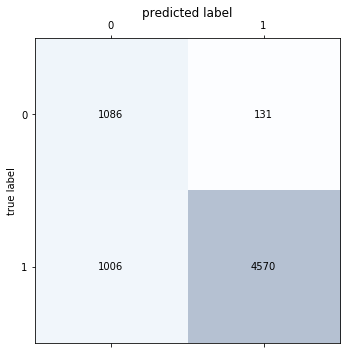

Epoch 3/5
15848/15848 [==============================] - 141s 9ms/step - loss: 0.1899 - acc: 0.9222 - val_loss: 0.3923 - val_acc: 0.8509
[0.8523160652119838, 0.7591867213223519, 0.7879728542258817]


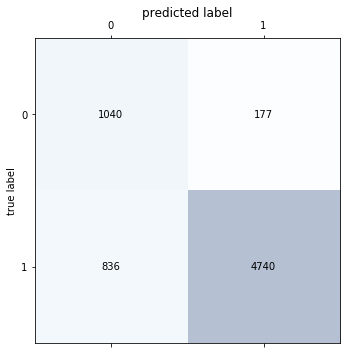

Epoch 4/5
15848/15848 [==============================] - 140s 9ms/step - loss: 0.1406 - acc: 0.9423 - val_loss: 0.4131 - val_acc: 0.8546
[0.8317542962031197, 0.7591088783913, 0.784827367754197]


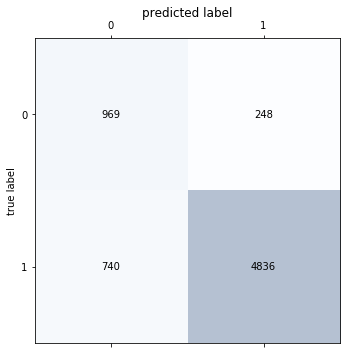

Epoch 5/5
15848/15848 [==============================] - 139s 9ms/step - loss: 0.0939 - acc: 0.9637 - val_loss: 0.4369 - val_acc: 0.8629
[0.8143831439824862, 0.7671804256849702, 0.7865491335393022]


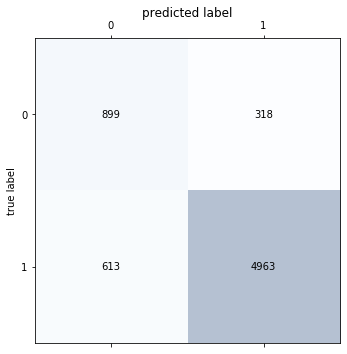

In [ ]:
Mcb = MCallback(model,x_test,Y_test)
history=model.fit(x_train,Y_train,batch_size=16,epochs=5,callbacks=[Mcb],
                  validation_data=(x_test,Y_test),class_weight=class_weight2)

# ELMoによる埋め込み


In [ ]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub

In [ ]:
#渡すのは文章
elmo=hub.Module("http://tfhub.dev/google/elmo/2",trainable=True)
def ELMoEmbedding(x):
  return elmo(tf.squeeze(tf.cast(x,tf.string)),signature='default',as_dict=True)['elmo']

In [ ]:

def build_model():
  inp =Input(shape=(None,),dtype='string')
  embedding = Lambda(ELMoEmbedding)(inp)
  dense = Dense(256,activation='relu')(embedding)
  pool = GlobalMaxPooling1D()(dense)
  drop = Dropout(0.2)(pool)
  pred = Dense(1,activation='sigmoid')(drop)
  model = Model(inputs=inp,outputs=pred)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model
model_elmo = build_model()
model_elmo.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 256)         262400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_____________________________________________________

In [ ]:
plot_model(model_elmo,show_shapes=True,to_file='ELMo.model.png')

Train on 15848 samples, validate on 6793 samples
Epoch 1/5
15848/15848 [==============================] - 311s 20ms/step - loss: 0.3881 - acc: 0.8265 - val_loss: 0.4456 - val_acc: 0.8173
[0.8620618768781336, 0.7381620256580562, 0.7615931281823037]


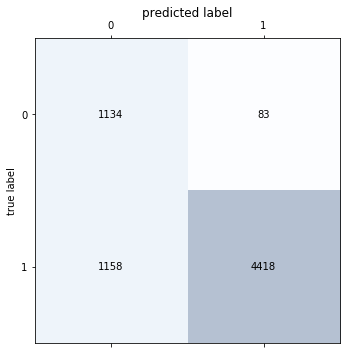


Epoch 00001: val_acc improved from -inf to 0.81731, saving model to 3_7.elmol.hdf5
Epoch 2/5
15848/15848 [==============================] - 311s 20ms/step - loss: 0.2544 - acc: 0.8916 - val_loss: 0.2339 - val_acc: 0.9021
[0.8234612566593065, 0.837308829355353, 0.8301160196030464]


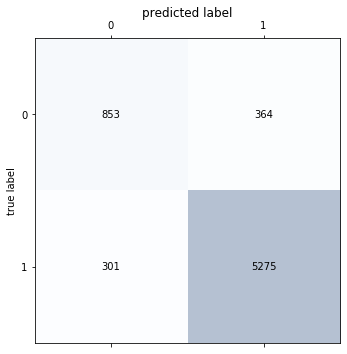


Epoch 00002: val_acc improved from 0.81731 to 0.90211, saving model to 3_7.elmol.hdf5
Epoch 3/5
15848/15848 [==============================] - 315s 20ms/step - loss: 0.1847 - acc: 0.9242 - val_loss: 0.2649 - val_acc: 0.8947
[0.8706871449303212, 0.812970221122591, 0.8366976663477386]


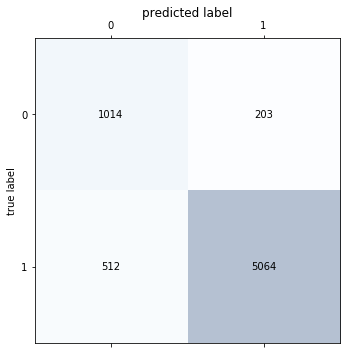


Epoch 00003: val_acc did not improve from 0.90211
Epoch 4/5
15848/15848 [==============================] - 314s 20ms/step - loss: 0.1378 - acc: 0.9457 - val_loss: 0.3727 - val_acc: 0.8668
[0.8844827697999055, 0.7799286095929652, 0.811944097122646]


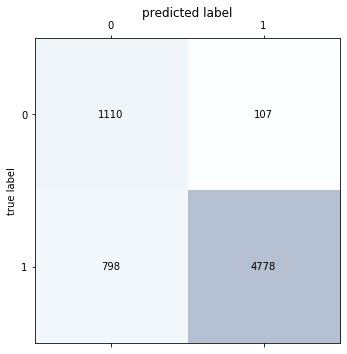


Epoch 00004: val_acc did not improve from 0.90211
Epoch 5/5
15848/15848 [==============================] - 310s 20ms/step - loss: 0.1134 - acc: 0.9543 - val_loss: 0.2772 - val_acc: 0.8980
[0.8649516533470714, 0.8187058982800972, 0.838619247855938]


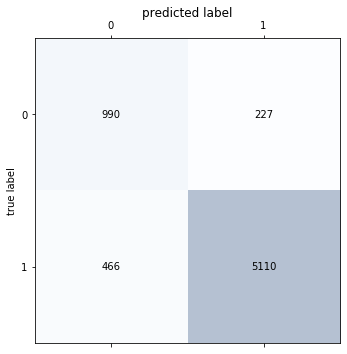


Epoch 00005: val_acc did not improve from 0.90211


In [ ]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  mc = ModelCheckpoint(filepath='3_7.elmol.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
  Mcb = MCallback(model_elmo,X_test,Y_test)
  history = model_elmo.fit(X_train,Y_train,epochs=5,batch_size=32,
                           validation_data=(X_test,Y_test),callbacks=[Mcb,mc],
                           class_weight=class_weight2)

Train on 15848 samples, validate on 6793 samples
Epoch 1/5



15848/15848 [==============================] - 818s 52ms/step - loss: 0.4200 - acc: 0.8090 - val_loss: 0.4021 - val_acc: 0.8319
[0.8702968556402659, 0.7493344516596092, 0.7762642949515879]


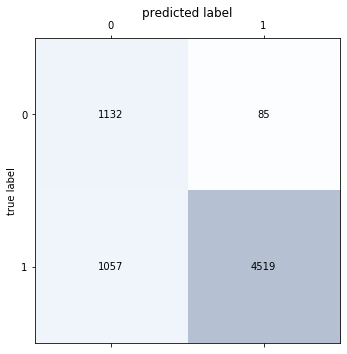


Epoch 00001: val_acc improved from -inf to 0.83189, saving model to 3_9.elmol.hdf5
Epoch 2/5
15848/15848 [==============================] - 799s 50ms/step - loss: 0.2900 - acc: 0.8775 - val_loss: 0.3839 - val_acc: 0.8476
[0.8808550761627777, 0.7630770538393573, 0.7930834915574329]


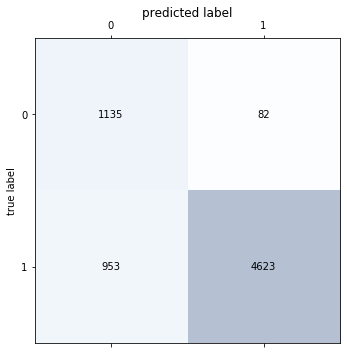


Epoch 00002: val_acc improved from 0.83189 to 0.84764, saving model to 3_9.elmol.hdf5
Epoch 3/5
15848/15848 [==============================] - 795s 50ms/step - loss: 0.2388 - acc: 0.9015 - val_loss: 0.3071 - val_acc: 0.8793
[0.8763670808925209, 0.7921455452226531, 0.822119667447643]


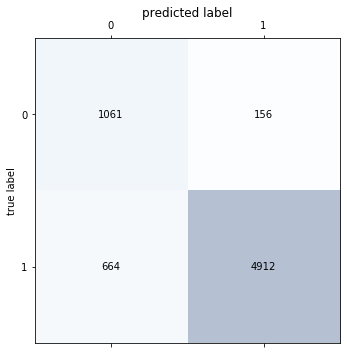


Epoch 00003: val_acc improved from 0.84764 to 0.87929, saving model to 3_9.elmol.hdf5
Epoch 4/5
15848/15848 [==============================] - 793s 50ms/step - loss: 0.2029 - acc: 0.9163 - val_loss: 0.2351 - val_acc: 0.9039
[0.826464354806195, 0.8404404919563955, 0.8331815951891568]


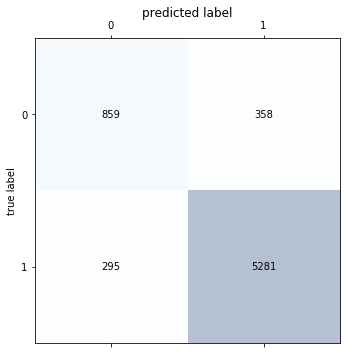


Epoch 00004: val_acc improved from 0.87929 to 0.90387, saving model to 3_9.elmol.hdf5
Epoch 5/5
15848/15848 [==============================] - 790s 50ms/step - loss: 0.1690 - acc: 0.9313 - val_loss: 0.3073 - val_acc: 0.8849
[0.8768839544756316, 0.799058075135092, 0.8279763084435982]


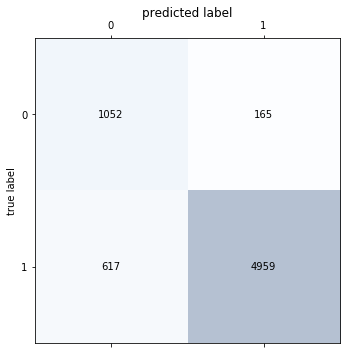


Epoch 00005: val_acc did not improve from 0.90387


In [ ]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  mc = ModelCheckpoint(filepath='3_9.elmol.hdf5', monitor='val_acc', 
                     verbose=1, save_best_only=True, mode='max')
  Mcb = MCallback(model_elmo,X_test,Y_test)
  history = model_elmo.fit(X_train,Y_train,epochs=5,batch_size=32,
                           validation_data=(X_test,Y_test),callbacks=[Mcb,mc],
                           class_weight=class_weight2)